<a href="https://colab.research.google.com/github/PPatrickGU/ROB313/blob/main/ROB313_DeepLearning_Exercice2_Zheyi_Dajing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ROB313 - TP2 : Deep Learning** 

## **Exercice 2 : Re identification**

*Author: Zheyi SHEN & Dajing GU*

In [ ]:
import numpy as np
import os
import cv2
import re
from PIL import Image
import matplotlib as plt
import random
import math
import collections
from collections import defaultdict

from tqdm import tqdm
import torch
import torch.nn as nn
from torchvision.models.resnet import resnet50
from torchvision.models.resnet import resnet101
from torch.optim import lr_scheduler
import torchvision
from torch.utils.data import sampler
from torchvision import transforms
from torch.utils.data import dataset, dataloader
from torchvision.datasets.folder import default_loader
from torch.nn import CrossEntropyLoss
from torch.nn.modules import loss
from torch.optim import Adam, SGD
from scipy.spatial.distance import cdist
from sklearn.metrics import average_precision_score
from google.colab import drive
from google.colab.patches import cv2_imshow

In [ ]:
# First let us mount you google drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


## **Initialization of parser parameters**

In [ ]:
import argparse
parser = argparse.ArgumentParser(description='reid')

parser.add_argument('--data_path',
                    default="/drive/My Drive/Colab Notebooks/Exercice2//data/Market-1501-v15.09.15",
                    help='path of Market-1501-v15.09.15')
parser.add_argument('--mode',
                    default='train', choices=['train', 'evaluate'],
                    help='train or evaluate ')
parser.add_argument('--query_image',
                    default='0001_c1s1_001051_00.jpg',
                    help='path to the image you want to query')
parser.add_argument('--freeze',
                    default=False,
                    help='freeze backbone or not ')
parser.add_argument('--weight',
                    default='weights/model.pt',
                    help='load weights ')
parser.add_argument('--epoch',
                    default=500,
                    help='number of epoch to train')
parser.add_argument('--lr',
                    default=2e-4,
                    help='initial learning_rate')
parser.add_argument('--lr_scheduler',
                    default=[320, 380],
                    help='MultiStepLR,decay the learning rate')
parser.add_argument("--batchid",
                    default=4,
                    help='the batch for id') #4
parser.add_argument("--batchimage",
                    default=8,
                    help='the batch of per id') #4
parser.add_argument("--batchtest",
                    default=32,
                    help='the batch size for test')
opt=parser.parse_args(args=[])
print(opt)

Namespace(batchid=8, batchimage=8, batchtest=32, data_path='/drive/My Drive/Colab Notebooks/Exercice2//data/Market-1501-v15.09.15', epoch=1000, freeze=False, lr=0.0002, lr_scheduler=[320, 380], mode='train', query_image='0001_c1s1_001051_00.jpg', weight='weights/model.pt')


## **Import pre-defined functions**

In [ ]:
class Loss(loss._Loss):
    def __init__(self):
        super(Loss, self).__init__()

    def forward(self, outputs, labels):
        cross_entropy_loss = CrossEntropyLoss()
        triplet_loss = TripletLoss(margin=1.2)

        Triplet_Loss = triplet_loss(outputs[1], labels)
        #Triplet_Loss = sum(Triplet_Loss) / len(Triplet_Loss)

        CrossEntropy_Loss = cross_entropy_loss(outputs[2], labels)
        #CrossEntropy_Loss = sum(CrossEntropy_Loss) / len(CrossEntropy_Loss)

        loss_sum = Triplet_Loss + 2 * CrossEntropy_Loss

        print('\rtotal loss:%.2f  Triplet_Loss:%.2f  CrossEntropy_Loss:%.2f\n' % (
            loss_sum.data.cpu().numpy(),
            Triplet_Loss.data.cpu().numpy(),
            CrossEntropy_Loss.data.cpu().numpy()),
              end=' ')
        return loss_sum

In [ ]:
def get_optimizer(net):
    if opt.freeze:

        for p in net.parameters():
            p.requires_grad = True
        for q in net.backbone.parameters():
            q.requires_grad = False

        optimizer = Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=opt.lr, weight_decay=5e-4,
                         amsgrad=True)

    else:

        # optimizer = SGD(net.parameters(), lr=opt.lr,momentum=0.9, weight_decay=5e-4)
        optimizer = Adam(net.parameters(), lr=opt.lr, weight_decay=5e-4, amsgrad=True)

    return optimizer


In [ ]:
def extract_feature(model, loader):
    features = torch.FloatTensor()

    for (inputs, labels) in loader:

        input_img = inputs.to('cuda')
        outputs = model(input_img)
        f1 = outputs[0].data.cpu()

        # flip
        inputs = inputs.index_select(3, torch.arange(inputs.size(3) - 1, -1, -1))
        input_img = inputs.to('cuda')
        outputs = model(input_img)
        f2 = outputs[0].data.cpu()
        ff = f1 + f2

        fnorm = torch.norm(ff, p=2, dim=1, keepdim=True)
        ff = ff.div(fnorm.expand_as(ff))
        features = torch.cat((features, ff), 0)
    return features

In [ ]:
def _unique_sample(ids_dict, num):
    mask = np.zeros(num, dtype=np.bool)
    for _, indices in ids_dict.items():
        i = np.random.choice(indices)
        mask[i] = True
    return mask

In [ ]:
def cmc(distmat, query_ids=None, gallery_ids=None,
        query_cams=None, gallery_cams=None, topk=100,
        separate_camera_set=False,
        single_gallery_shot=False,
        first_match_break=False):
    m, n = distmat.shape
    # Fill up default values
    if query_ids is None:
        query_ids = np.arange(m)
    if gallery_ids is None:
        gallery_ids = np.arange(n)
    if query_cams is None:
        query_cams = np.zeros(m).astype(np.int32)
    if gallery_cams is None:
        gallery_cams = np.ones(n).astype(np.int32)
    # Ensure numpy array
    query_ids = np.asarray(query_ids)
    gallery_ids = np.asarray(gallery_ids)
    query_cams = np.asarray(query_cams)
    gallery_cams = np.asarray(gallery_cams)
    # Sort and find correct matches
    indices = np.argsort(distmat, axis=1)
    matches = (gallery_ids[indices] == query_ids[:, np.newaxis])
    # Compute CMC for each query
    ret = np.zeros(topk)
    num_valid_queries = 0
    for i in range(m):
        # Filter out the same id and same camera
        valid = ((gallery_ids[indices[i]] != query_ids[i]) |
                 (gallery_cams[indices[i]] != query_cams[i]))
        if separate_camera_set:
            # Filter out samples from same camera
            valid &= (gallery_cams[indices[i]] != query_cams[i])
        if not np.any(matches[i, valid]):
            continue
        if single_gallery_shot:
            repeat = 10
            gids = gallery_ids[indices[i][valid]]
            inds = np.where(valid)[0]
            ids_dict = defaultdict(list)
            for j, x in zip(inds, gids):
                ids_dict[x].append(j)
        else:
            repeat = 1
        for _ in range(repeat):
            if single_gallery_shot:
                # Randomly choose one instance for each id
                sampled = (valid & _unique_sample(ids_dict, len(valid)))
                index = np.nonzero(matches[i, sampled])[0]
            else:
                index = np.nonzero(matches[i, valid])[0]
            delta = 1. / (len(index) * repeat)
            for j, k in enumerate(index):
                if k - j >= topk:
                    break
                if first_match_break:
                    ret[k - j] += 1
                    break
                ret[k - j] += delta
        num_valid_queries += 1
    if num_valid_queries == 0:
        raise RuntimeError("No valid query")
    return ret.cumsum() / num_valid_queries

In [ ]:
def mean_ap(distmat, query_ids=None, gallery_ids=None,
            query_cams=None, gallery_cams=None):
    m, n = distmat.shape
    # Fill up default values
    if query_ids is None:
        query_ids = np.arange(m)
    if gallery_ids is None:
        gallery_ids = np.arange(n)
    if query_cams is None:
        query_cams = np.zeros(m).astype(np.int32)
    if gallery_cams is None:
        gallery_cams = np.ones(n).astype(np.int32)
    # Ensure numpy array
    query_ids = np.asarray(query_ids)
    gallery_ids = np.asarray(gallery_ids)
    query_cams = np.asarray(query_cams)
    gallery_cams = np.asarray(gallery_cams)
    # Sort and find correct matches
    indices = np.argsort(distmat, axis=1)
    matches = (gallery_ids[indices] == query_ids[:, np.newaxis])
    # Compute AP for each query
    aps = []
    for i in range(m):
        # Filter out the same id and same camera
        valid = ((gallery_ids[indices[i]] != query_ids[i]) |
                 (gallery_cams[indices[i]] != query_cams[i]))
        y_true = matches[i, valid]
        y_score = -distmat[i][indices[i]][valid]
        if not np.any(y_true):
            continue
        aps.append(average_precision_score(y_true, y_score))
    if len(aps) == 0:
        raise RuntimeError("No valid query")
    return np.mean(aps)

In [ ]:

class RandomErasing(object):
    """ Randomly selects a rectangle region in an image and erases its pixels.
        'Random Erasing Data Augmentation' by Zhong et al.
        See https://arxiv.org/pdf/1708.04896.pdf
    Args:
         probability: The probability that the Random Erasing operation will be performed.
         sl: Minimum proportion of erased area against input image.
         sh: Maximum proportion of erased area against input image.
         r1: Minimum aspect ratio of erased area.
         mean: Erasing value.
    """

    def __init__(self, probability=0.5, sl=0.02, sh=0.4, r1=0.3, mean=[0.4914, 0.4822, 0.4465]):
        self.probability = probability
        self.mean = mean
        self.sl = sl
        self.sh = sh
        self.r1 = r1

    def __call__(self, img):

        if random.uniform(0, 1) > self.probability:
            return img

        for attempt in range(100):
            area = img.size()[1] * img.size()[2]

            target_area = random.uniform(self.sl, self.sh) * area
            aspect_ratio = random.uniform(self.r1, 1 / self.r1)

            h = int(round(math.sqrt(target_area * aspect_ratio)))
            w = int(round(math.sqrt(target_area / aspect_ratio)))

            if w < img.size()[2] and h < img.size()[1]:
                x1 = random.randint(0, img.size()[1] - h)
                y1 = random.randint(0, img.size()[2] - w)
                if img.size()[0] == 3:
                    img[0, x1:x1 + h, y1:y1 + w] = self.mean[0]
                    img[1, x1:x1 + h, y1:y1 + w] = self.mean[1]
                    img[2, x1:x1 + h, y1:y1 + w] = self.mean[2]
                else:
                    img[0, x1:x1 + h, y1:y1 + w] = self.mean[0]
                return img

        return img


## **Q1: Have a look at the dataset and plot the images**

Image Dimension: 128 lines x 64 columns 3 channels


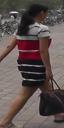

Image Dimension: 128 lines x 64 columns 3 channels


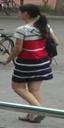

Image Dimension: 128 lines x 64 columns 3 channels


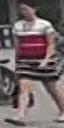

In [ ]:
# Let us read the image

path = '/drive/My Drive/Colab Notebooks/Exercice2//data/Market-1501-v15.09.15/bounding_box_train/'

imagelist = os.listdir(path)

num = 0

for imgname in imagelist:
  if num < 3:
    if (imgname.endswith(".jpg")):
        image = cv2.imread(path + imgname)
        (h,w, c) = image.shape
        print("Image Dimension:",h,"lines x",w,"columns", c,"channels")
        cv2_imshow(image)
        num += 1

## **Q2: Implement the triplet loss**

In [ ]:
class TripletLoss(nn.Module):
    """Triplet loss with hard positive/negative mining.
    Reference:
    Hermans et al. In Defense of the Triplet Loss for Person Re-Identification. arXiv:1703.07737.
    Code imported from https://github.com/Cysu/open-reid/blob/master/reid/loss/triplet.py.
    Args:
        margin (float): margin for triplet.
    """

    def __init__(self, margin=0.3):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.ranking_loss = nn.MarginRankingLoss(margin=margin)


    def forward(self, inputs, targets):
        """
        Args:
            inputs: feature matrix with shape (batch_size, feat_dim)
            targets: ground truth labels with shape (num_classes)
            return the loss
            # PLEASE WRITE THIS Method
        """
        n = inputs.size(0) #16

        # Compute pairwise distance, replace by the official when merged
        dist = torch.pow(inputs, 2).sum(dim=1, keepdim=True).expand(n, n)
        dist = dist + dist.t()
        dist.addmm_(1, -2, inputs, inputs.t())
        dist = dist.clamp(min=1e-12).sqrt()  # for numerical stability

        # For each anchor, find the hardest positive and negative
        mask = targets.expand(n, n).eq(targets.expand(n, n).t())
        dist_ap, dist_an = [], []
        for i in range(n):
            dist_ap.append(dist[i][mask[i]].max())
            dist_an.append(dist[i][mask[i] == 0].min())
        dist_ap = torch.stack(dist_ap) #dist_ap = torch.cat(dist_ap)
        dist_an = torch.stack(dist_an) #dist_an = torch.cat(dist_an)

        # Compute ranking hinge loss
        y = dist_an.data.new()
        y.resize_as_(dist_an.data)
        y.fill_(1)
        loss = self.ranking_loss(dist_an, dist_ap, y)
        prec = (dist_an.data > dist_ap.data).sum() * 1. / y.size(0)
        return loss


## **Q3: Describe a sampler**

In [ ]:
class RandomSampler(sampler.Sampler):
    def __init__(self, data_source, batch_id, batch_image):
        super(RandomSampler, self).__init__(data_source)

        self.data_source = data_source
        self.batch_image = batch_image
        self.batch_id = batch_id

        self._id2index = collections.defaultdict(list)
        for idx, path in enumerate(data_source.imgs):
            _id = data_source.get_id(path)
            self._id2index[_id].append(idx)

    def __iter__(self):
        unique_ids = self.data_source.unique_ids
        random.shuffle(unique_ids)

        imgs = []
        for _id in unique_ids:
            imgs.extend(self._sample(self._id2index[_id], self.batch_image))
        return iter(imgs)

    def __len__(self):
        return len(self._id2index) * self.batch_image

    @staticmethod # it is a method that does not require self variable => it cannot modify any self variables
    def _sample(population, k):
        if len(population) < k:
            population = population * k
        return random.sample(population, k)

In [ ]:
class RandomIdentitySampler(sampler.Sampler):
    def __init__(self, data_source, num_instances):
        self.data_source = data_source
        self.num_instances = num_instances
        self.index_dic = defaultdict(list)
        for index, (_, pid, _) in enumerate(data_source):
            self.index_dic[pid].append(index)
        self.pids = list(self.index_dic.keys())
        self.num_samples = len(self.pids)

    def __len__(self):
        return self.num_samples * self.num_instances

    def __iter__(self):
        indices = torch.randperm(self.num_samples).tolist()
        ret = []
        for i in indices:
            pid = self.pids[i]
            t = self.index_dic[pid]
            if len(t) >= self.num_instances:
                t = np.random.choice(t, size=self.num_instances, replace=False)
            else:
                t = np.random.choice(t, size=self.num_instances, replace=True)
            ret.extend(t)
        return iter(ret)

## **Q4: Complete the dataset class**

In [ ]:
class Data():
    def __init__(self):
        train_transform = transforms.Compose([
            transforms.Resize((384, 128), interpolation=3),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            RandomErasing(probability=0.5, mean=[0.0, 0.0, 0.0])
        ])

        test_transform = transforms.Compose([
            transforms.Resize((384, 128), interpolation=3),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.trainset = Market1501(train_transform, 'train', opt.data_path)
        self.testset = Market1501(test_transform, 'test', opt.data_path)
        self.queryset = Market1501(test_transform, 'query', opt.data_path)

        self.train_loader = dataloader.DataLoader(self.trainset,
                                                  sampler=RandomSampler(self.trainset, batch_id=opt.batchid,
                                                                        batch_image=opt.batchimage),
                                                  batch_size=opt.batchid * opt.batchimage, num_workers=8,
                                                  pin_memory=False)#8

        self.test_loader = dataloader.DataLoader(self.testset, batch_size=opt.batchtest, num_workers=8, pin_memory=True)#8
        self.query_loader = dataloader.DataLoader(self.queryset, batch_size=opt.batchtest, num_workers=8,
                                                  pin_memory=False)#8

        if opt.mode == 'vis':
            self.query_image = test_transform(default_loader(opt.query_image))


In [ ]:
class Market1501(dataset.Dataset):
    def __init__(self, transform, dtype, data_path):

        self.transform = transform
        self.loader = default_loader
        self.data_path = data_path

        if dtype == 'train':
            self.data_path += '/bounding_box_train'
        elif dtype == 'test':
            self.data_path += '/bounding_box_test'
        else:
            self.data_path += '/query'

        self.imgs = [path for path in self.list_pictures(self.data_path) if int(path.split('/')[-1].split('_')[0])  != -1]

        num_pids, num_imgs, num_cams, = self.get_imagedata_info(self.imgs)
        print("Dataset statistics:")
        print("  ----------------------------------------")
        print("  subset   | # ids | # images | # cameras")
        print("  ----------------------------------------")
        print("  ", dtype ," |", str(num_pids) , "| ", str(num_imgs) ," | ", str(num_cams) )
        print("  ----------------------------------------")

        self.ids, self.cameras = self.get_id_cam()
        self.unique_ids = sorted(set(self.ids))
        self._id2label = {_id: idx for idx, _id in enumerate(self.unique_ids)} # Build a dictionary where the key is the id and the element is the label
        # print(self._id2label)

    def __getitem__(self, index):
        # please write the __getitem__ method
        assert index <= len(self), 'index range error'
        img = Image.open(self.imgs[index-1]) #3*64*128
        target = self._id2label[self.get_id(self.imgs[index-1])]
        if self.transform is not None:
            img = self.transform(img)
        return img, target

    def __len__(self):
        # please write the __len__ method
        # return len(self.data_path)
        return len(self.imgs)

    def get_id_cam(self):
        """"
        :return: person id list and camera list corresponding to dataset image paths
        """
        return [int(file_path.split('/')[-1].split('_')[0]) for file_path in self.imgs], [int(file_path.split('/')[-1].split('_')[1][1]) for file_path in self.imgs]

    def get_id(self,file_path):
        """
        :param file_path: unix style file path
        :return: person id
        """
        return int(file_path.split('/')[-1].split('_')[0])

    def list_pictures(self, directory, ext='jpg|jpeg|bmp|png|ppm|npy'):
        assert os.path.isdir(directory), 'dataset does not exists!{}'.format(directory)
        return sorted([os.path.join(root, f).replace('\\','/')
                       for root, _, files in os.walk(directory) for f in files if re.match(r'([\w]+\.(?:' + ext + '))', f)])

    def get_imagedata_info(self, data):
        pids, cams = [], []

        for file_path in data:
            camid = int(file_path.split('/')[-1].split('_')[1][1])
            pid=int(file_path.split('/')[-1].split('_')[0])
            pids += [pid]
            cams += [camid]
        pids = set(pids)
        cams = set(cams)
        num_pids = len(pids)
        num_cams = len(cams)
        num_imgs = len(data)
        return num_pids, num_imgs, num_cams

## **Q5 : Create our own DNN**


In [ ]:
num_classes = 751  # change this depend on your dataset

class REID_NET_50(nn.Module):
    def __init__(self):
        # write the CNN initialization
        super(REID_NET_50, self).__init__()
        model = resnet50(pretrained=True)
        self.fc_hidden1=1024
        self.fc_hidden2=768
        self.resnet = torch.nn.Sequential(*(list(model.children())[:-1])) # delete the last FC layer of resnet

        fc_features = model.fc.in_features

        self.fc_id = nn.Sequential(
                        nn.Linear(fc_features, self.fc_hidden1),
                        nn.Linear(self.fc_hidden1, num_classes)
                        )
        self.fc_metric = nn.Sequential(
                        nn.Linear(fc_features, self.fc_hidden1),
                        nn.Linear(self.fc_hidden1, num_classes)
                        )

    def forward(self, x):
        # write the CNN forward
        # print('begin training')

        x = self.resnet(x).squeeze()  # ResNet without the last FC layer

        predict_id= self.fc_id(x) # Write this layer

        predict_metric= self.fc_metric(x) # Write this layer

        predict = torch.cat([predict_id, predict_metric], dim=1)

        return predict, predict_id, predict_metric


class REID_NET_101(nn.Module):
    def __init__(self):
        # write the CNN initialization
        super(REID_NET_101, self).__init__()
        model = resnet101(pretrained=True)
        self.fc_hidden1=1024
        self.fc_hidden2=768
        self.resnet = torch.nn.Sequential(*(list(model.children())[:-1])) # delete the last FC layer of resnet

        fc_features = model.fc.in_features

        self.fc_id = nn.Sequential(
                        nn.Linear(fc_features, self.fc_hidden1),
                        nn.Linear(self.fc_hidden1, num_classes)
                        )
        self.fc_metric = nn.Sequential(
                        nn.Linear(fc_features, self.fc_hidden1),
                        nn.Linear(self.fc_hidden1, num_classes)
                        )

    def forward(self, x):
        # write the CNN forward
        # print('begin training')

        x = self.resnet(x).squeeze()  # ResNet without the last FC layer

        predict_id= self.fc_id(x) # Write this layer

        predict_metric= self.fc_metric(x) # Write this layer

        predict = torch.cat([predict_id, predict_metric], dim=1)

        return predict, predict_id, predict_metric

## **Q6 : Write a training code and train the DNN**

In [ ]:
def train(model,train_loader,scheduler,optimizer,loss_function):
    # PLEASE COMPLETE THE TRAINING FUNCTION
    model.train()
    print("Begin training:")
    for (inputs, targets) in train_loader:
        inputs, targets = inputs.to('cuda'), targets.to('cuda')
        # zeroes the gradient buffers of all parameters
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
    scheduler.step()

In [ ]:
def evaluate(model, query_loader, test_loader, queryset, testset):
    model.eval()
    print("Begin training:")
    print('extract features, this may take a few minutes')
    qf = extract_feature(model, tqdm(query_loader)).numpy()
    gf = extract_feature(model, tqdm(test_loader)).numpy()

    print('\n', qf.shape)
    print(gf.shape)

    def rank(dist):
        r = cmc(dist, queryset.ids, testset.ids, queryset.cameras, testset.cameras,
                    separate_camera_set=False,
                    single_gallery_shot=False,
                    first_match_break=True)
        m_ap = mean_ap(dist, queryset.ids, testset.ids, queryset.cameras, testset.cameras)

        return r, m_ap
        ######################### evaluation without rank##########################
    dist = cdist(qf, gf)

    r, m_ap = rank(dist)

    print('[Without Re-Ranking] mAP: {:.4f} rank1: {:.4f} rank3: {:.4f} rank5: {:.4f} rank10: {:.4f}'
              .format(m_ap, r[0], r[2], r[4], r[9]))

### **Result of ResNet 50**

In [ ]:
data = Data()

model = REID_NET50()
# print(model)
model = model.to('cuda')
loss_function = Loss()
optimizer = get_optimizer(model)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=opt.lr_scheduler, gamma=0.1)

if opt.mode == 'train':
    for epoch in range(1, opt.epoch + 1):
        print('\nepoch', epoch)
        train(model,data.train_loader,scheduler,optimizer,loss_function)
        if epoch % 50 == 0:
            print('\nstart evaluate')
            evaluate(model, data.query_loader, data.test_loader, data.queryset, data.testset)
            os.makedirs('weights', exist_ok=True)
            torch.save(model.state_dict(), ('weights/model_{}.pt'.format(epoch)))

if opt.mode == 'evaluate':
    print('start evaluate')
    model.load_state_dict(torch.load(opt.weight))
    evaluate(model,data.query_loader,data.test_loader,data.queryset,data.testset)

流式输出内容被截断，只能显示最后 5000 行内容。
total loss:7.49  Triplet_Loss:0.10  CrossEntropy_Loss:3.70
total loss:6.97  Triplet_Loss:0.01  CrossEntropy_Loss:3.48
total loss:8.14  Triplet_Loss:0.05  CrossEntropy_Loss:4.05
total loss:8.07  Triplet_Loss:0.68  CrossEntropy_Loss:3.69
total loss:7.43  Triplet_Loss:0.30  CrossEntropy_Loss:3.57
total loss:6.74  Triplet_Loss:0.02  CrossEntropy_Loss:3.36
total loss:6.26  Triplet_Loss:0.11  CrossEntropy_Loss:3.07
total loss:10.28  Triplet_Loss:1.48  CrossEntropy_Loss:4.40
total loss:5.89  Triplet_Loss:0.00  CrossEntropy_Loss:2.94
total loss:9.42  Triplet_Loss:1.41  CrossEntropy_Loss:4.00
total loss:6.66  Triplet_Loss:0.36  CrossEntropy_Loss:3.15
total loss:9.77  Triplet_Loss:1.50  CrossEntropy_Loss:4.13
total loss:7.38  Triplet_Loss:0.01  CrossEntropy_Loss:3.68
total loss:7.10  Triplet_Loss:0.01  CrossEntropy_Loss:3.55
total loss:8.23  Triplet_Loss:0.26  CrossEntropy_Loss:3.98
total loss:5.97  Triplet_Loss:0.09  CrossEntropy_Loss:2.94
total loss:7.86  Triplet_Los

  0%|          | 0/106 [00:00<?, ?it/s]


start evaluate
Begin training:
extract features, this may take a few minutes


100%|██████████| 498/498 [02:09<00:00,  3.83it/s]


流式输出内容被截断，只能显示最后 5000 行内容。
total loss:1.37  Triplet_Loss:0.02  CrossEntropy_Loss:0.67
total loss:2.59  Triplet_Loss:0.00  CrossEntropy_Loss:1.30
total loss:2.77  Triplet_Loss:0.69  CrossEntropy_Loss:1.04
total loss:0.70  Triplet_Loss:0.02  CrossEntropy_Loss:0.34
total loss:1.81  Triplet_Loss:0.00  CrossEntropy_Loss:0.90
total loss:2.77  Triplet_Loss:0.67  CrossEntropy_Loss:1.05
total loss:1.12  Triplet_Loss:0.00  CrossEntropy_Loss:0.56
total loss:1.68  Triplet_Loss:0.13  CrossEntropy_Loss:0.77
total loss:1.61  Triplet_Loss:0.05  CrossEntropy_Loss:0.78
total loss:2.43  Triplet_Loss:0.43  CrossEntropy_Loss:1.00
total loss:1.39  Triplet_Loss:0.00  CrossEntropy_Loss:0.69
total loss:0.30  Triplet_Loss:0.00  CrossEntropy_Loss:0.15
total loss:2.08  Triplet_Loss:0.02  CrossEntropy_Loss:1.03
total loss:1.98  Triplet_Loss:0.00  CrossEntropy_Loss:0.99
total loss:0.67  Triplet_Loss:0.00  CrossEntropy_Loss:0.33
total loss:0.48  Triplet_Loss:0.00  CrossEntropy_Loss:0.24
total loss:1.99  Triplet_Loss

  0%|          | 0/106 [00:00<?, ?it/s]


start evaluate
Begin training:
extract features, this may take a few minutes


100%|██████████| 498/498 [02:09<00:00,  3.86it/s]


流式输出内容被截断，只能显示最后 5000 行内容。
total loss:3.63  Triplet_Loss:1.15  CrossEntropy_Loss:1.24
total loss:1.37  Triplet_Loss:0.04  CrossEntropy_Loss:0.66
total loss:0.54  Triplet_Loss:0.35  CrossEntropy_Loss:0.10
total loss:0.53  Triplet_Loss:0.00  CrossEntropy_Loss:0.27
total loss:0.32  Triplet_Loss:0.00  CrossEntropy_Loss:0.16
total loss:0.73  Triplet_Loss:0.09  CrossEntropy_Loss:0.32
total loss:0.97  Triplet_Loss:0.09  CrossEntropy_Loss:0.44
total loss:1.57  Triplet_Loss:0.02  CrossEntropy_Loss:0.77
total loss:1.70  Triplet_Loss:0.24  CrossEntropy_Loss:0.73
total loss:1.00  Triplet_Loss:0.28  CrossEntropy_Loss:0.36
total loss:0.45  Triplet_Loss:0.23  CrossEntropy_Loss:0.11
total loss:0.63  Triplet_Loss:0.00  CrossEntropy_Loss:0.32
total loss:0.97  Triplet_Loss:0.24  CrossEntropy_Loss:0.36
total loss:1.10  Triplet_Loss:0.00  CrossEntropy_Loss:0.55
total loss:0.49  Triplet_Loss:0.00  CrossEntropy_Loss:0.24
total loss:0.24  Triplet_Loss:0.00  CrossEntropy_Loss:0.12
total loss:0.58  Triplet_Loss

  0%|          | 0/106 [00:00<?, ?it/s]


start evaluate
Begin training:
extract features, this may take a few minutes


100%|██████████| 498/498 [02:09<00:00,  3.85it/s]


流式输出内容被截断，只能显示最后 5000 行内容。
total loss:0.15  Triplet_Loss:0.00  CrossEntropy_Loss:0.07
total loss:1.15  Triplet_Loss:0.01  CrossEntropy_Loss:0.57
total loss:1.58  Triplet_Loss:0.04  CrossEntropy_Loss:0.77
total loss:2.42  Triplet_Loss:1.23  CrossEntropy_Loss:0.59
total loss:1.43  Triplet_Loss:0.23  CrossEntropy_Loss:0.60
total loss:1.34  Triplet_Loss:0.30  CrossEntropy_Loss:0.52
total loss:0.30  Triplet_Loss:0.13  CrossEntropy_Loss:0.09
total loss:0.05  Triplet_Loss:0.00  CrossEntropy_Loss:0.02
total loss:0.42  Triplet_Loss:0.19  CrossEntropy_Loss:0.11
total loss:1.51  Triplet_Loss:0.01  CrossEntropy_Loss:0.75
total loss:0.22  Triplet_Loss:0.00  CrossEntropy_Loss:0.11
total loss:1.16  Triplet_Loss:0.00  CrossEntropy_Loss:0.58
total loss:0.36  Triplet_Loss:0.04  CrossEntropy_Loss:0.16
total loss:0.69  Triplet_Loss:0.00  CrossEntropy_Loss:0.34
total loss:0.08  Triplet_Loss:0.00  CrossEntropy_Loss:0.04
total loss:1.01  Triplet_Loss:0.00  CrossEntropy_Loss:0.51
total loss:0.58  Triplet_Loss

  0%|          | 0/106 [00:00<?, ?it/s]


start evaluate
Begin training:
extract features, this may take a few minutes


100%|██████████| 498/498 [02:09<00:00,  3.85it/s]


流式输出内容被截断，只能显示最后 5000 行内容。
total loss:0.12  Triplet_Loss:0.00  CrossEntropy_Loss:0.06
total loss:0.31  Triplet_Loss:0.00  CrossEntropy_Loss:0.16
total loss:0.07  Triplet_Loss:0.00  CrossEntropy_Loss:0.04
total loss:0.27  Triplet_Loss:0.03  CrossEntropy_Loss:0.12
total loss:0.62  Triplet_Loss:0.00  CrossEntropy_Loss:0.31
total loss:0.09  Triplet_Loss:0.00  CrossEntropy_Loss:0.05
total loss:0.29  Triplet_Loss:0.00  CrossEntropy_Loss:0.15
total loss:0.34  Triplet_Loss:0.12  CrossEntropy_Loss:0.11
total loss:0.11  Triplet_Loss:0.00  CrossEntropy_Loss:0.05
total loss:0.26  Triplet_Loss:0.00  CrossEntropy_Loss:0.13
total loss:0.54  Triplet_Loss:0.00  CrossEntropy_Loss:0.27
total loss:1.30  Triplet_Loss:0.00  CrossEntropy_Loss:0.65
total loss:0.74  Triplet_Loss:0.00  CrossEntropy_Loss:0.37
total loss:0.57  Triplet_Loss:0.00  CrossEntropy_Loss:0.28
total loss:0.04  Triplet_Loss:0.00  CrossEntropy_Loss:0.02
total loss:0.35  Triplet_Loss:0.00  CrossEntropy_Loss:0.18
total loss:0.08  Triplet_Loss

  0%|          | 0/106 [00:00<?, ?it/s]


start evaluate
Begin training:
extract features, this may take a few minutes


100%|██████████| 498/498 [02:08<00:00,  3.86it/s]


流式输出内容被截断，只能显示最后 5000 行内容。
total loss:1.00  Triplet_Loss:0.22  CrossEntropy_Loss:0.39
total loss:0.30  Triplet_Loss:0.00  CrossEntropy_Loss:0.15
total loss:0.08  Triplet_Loss:0.01  CrossEntropy_Loss:0.03
total loss:0.50  Triplet_Loss:0.01  CrossEntropy_Loss:0.25
total loss:0.06  Triplet_Loss:0.00  CrossEntropy_Loss:0.03
total loss:1.18  Triplet_Loss:0.25  CrossEntropy_Loss:0.47
total loss:0.97  Triplet_Loss:0.41  CrossEntropy_Loss:0.28
total loss:0.06  Triplet_Loss:0.00  CrossEntropy_Loss:0.03
total loss:0.27  Triplet_Loss:0.00  CrossEntropy_Loss:0.14
total loss:0.11  Triplet_Loss:0.00  CrossEntropy_Loss:0.05
total loss:0.50  Triplet_Loss:0.09  CrossEntropy_Loss:0.20
total loss:1.23  Triplet_Loss:0.38  CrossEntropy_Loss:0.43
total loss:2.74  Triplet_Loss:1.31  CrossEntropy_Loss:0.72
total loss:0.15  Triplet_Loss:0.00  CrossEntropy_Loss:0.08
total loss:0.26  Triplet_Loss:0.00  CrossEntropy_Loss:0.13
total loss:0.13  Triplet_Loss:0.00  CrossEntropy_Loss:0.06
total loss:0.13  Triplet_Loss

  0%|          | 0/106 [00:00<?, ?it/s]


start evaluate
Begin training:
extract features, this may take a few minutes


100%|██████████| 498/498 [02:11<00:00,  3.78it/s]


流式输出内容被截断，只能显示最后 5000 行内容。
total loss:0.26  Triplet_Loss:0.00  CrossEntropy_Loss:0.13
total loss:0.02  Triplet_Loss:0.00  CrossEntropy_Loss:0.01
total loss:0.14  Triplet_Loss:0.00  CrossEntropy_Loss:0.07
total loss:0.03  Triplet_Loss:0.00  CrossEntropy_Loss:0.02
total loss:0.35  Triplet_Loss:0.00  CrossEntropy_Loss:0.17
total loss:0.02  Triplet_Loss:0.00  CrossEntropy_Loss:0.01
total loss:0.46  Triplet_Loss:0.32  CrossEntropy_Loss:0.07
total loss:0.09  Triplet_Loss:0.03  CrossEntropy_Loss:0.03
total loss:0.23  Triplet_Loss:0.08  CrossEntropy_Loss:0.07
total loss:0.08  Triplet_Loss:0.00  CrossEntropy_Loss:0.04
total loss:0.14  Triplet_Loss:0.10  CrossEntropy_Loss:0.02
total loss:0.04  Triplet_Loss:0.00  CrossEntropy_Loss:0.02
total loss:0.16  Triplet_Loss:0.00  CrossEntropy_Loss:0.08
total loss:0.04  Triplet_Loss:0.00  CrossEntropy_Loss:0.02
total loss:0.02  Triplet_Loss:0.00  CrossEntropy_Loss:0.01
total loss:0.11  Triplet_Loss:0.08  CrossEntropy_Loss:0.01
total loss:0.09  Triplet_Loss

  0%|          | 0/106 [00:00<?, ?it/s]


start evaluate
Begin training:
extract features, this may take a few minutes


100%|██████████| 498/498 [02:10<00:00,  3.83it/s]


流式输出内容被截断，只能显示最后 5000 行内容。
total loss:0.02  Triplet_Loss:0.00  CrossEntropy_Loss:0.01
total loss:0.04  Triplet_Loss:0.00  CrossEntropy_Loss:0.02
total loss:0.73  Triplet_Loss:0.03  CrossEntropy_Loss:0.35
total loss:0.03  Triplet_Loss:0.00  CrossEntropy_Loss:0.01
total loss:0.03  Triplet_Loss:0.00  CrossEntropy_Loss:0.02
total loss:0.05  Triplet_Loss:0.00  CrossEntropy_Loss:0.02
total loss:0.03  Triplet_Loss:0.00  CrossEntropy_Loss:0.02
total loss:0.01  Triplet_Loss:0.00  CrossEntropy_Loss:0.00
total loss:0.01  Triplet_Loss:0.00  CrossEntropy_Loss:0.00
total loss:0.01  Triplet_Loss:0.00  CrossEntropy_Loss:0.00
total loss:0.05  Triplet_Loss:0.00  CrossEntropy_Loss:0.03
total loss:0.01  Triplet_Loss:0.00  CrossEntropy_Loss:0.01
total loss:0.03  Triplet_Loss:0.00  CrossEntropy_Loss:0.01
total loss:0.02  Triplet_Loss:0.00  CrossEntropy_Loss:0.01
total loss:0.59  Triplet_Loss:0.11  CrossEntropy_Loss:0.24
total loss:0.01  Triplet_Loss:0.00  CrossEntropy_Loss:0.01
total loss:0.04  Triplet_Loss

  0%|          | 0/106 [00:00<?, ?it/s]


start evaluate
Begin training:
extract features, this may take a few minutes


100%|██████████| 498/498 [02:12<00:00,  3.77it/s]


流式输出内容被截断，只能显示最后 5000 行内容。
total loss:0.23  Triplet_Loss:0.00  CrossEntropy_Loss:0.12
total loss:0.01  Triplet_Loss:0.00  CrossEntropy_Loss:0.00
total loss:0.12  Triplet_Loss:0.09  CrossEntropy_Loss:0.02
total loss:0.02  Triplet_Loss:0.00  CrossEntropy_Loss:0.01
total loss:0.07  Triplet_Loss:0.00  CrossEntropy_Loss:0.04
total loss:0.02  Triplet_Loss:0.00  CrossEntropy_Loss:0.01
total loss:0.02  Triplet_Loss:0.00  CrossEntropy_Loss:0.01
total loss:0.10  Triplet_Loss:0.07  CrossEntropy_Loss:0.02
total loss:0.44  Triplet_Loss:0.09  CrossEntropy_Loss:0.17
total loss:0.01  Triplet_Loss:0.00  CrossEntropy_Loss:0.01
total loss:0.06  Triplet_Loss:0.02  CrossEntropy_Loss:0.02
total loss:0.01  Triplet_Loss:0.00  CrossEntropy_Loss:0.00
total loss:0.03  Triplet_Loss:0.00  CrossEntropy_Loss:0.01
total loss:0.02  Triplet_Loss:0.00  CrossEntropy_Loss:0.01
total loss:0.01  Triplet_Loss:0.00  CrossEntropy_Loss:0.00
total loss:0.01  Triplet_Loss:0.00  CrossEntropy_Loss:0.00
total loss:0.01  Triplet_Loss

  0%|          | 0/106 [00:00<?, ?it/s]


start evaluate
Begin training:
extract features, this may take a few minutes


100%|██████████| 498/498 [02:09<00:00,  3.83it/s]


流式输出内容被截断，只能显示最后 5000 行内容。
total loss:0.05  Triplet_Loss:0.00  CrossEntropy_Loss:0.03
total loss:0.02  Triplet_Loss:0.00  CrossEntropy_Loss:0.01
total loss:0.10  Triplet_Loss:0.00  CrossEntropy_Loss:0.05
total loss:0.69  Triplet_Loss:0.08  CrossEntropy_Loss:0.30
total loss:0.02  Triplet_Loss:0.00  CrossEntropy_Loss:0.01
total loss:0.01  Triplet_Loss:0.00  CrossEntropy_Loss:0.01
total loss:0.00  Triplet_Loss:0.00  CrossEntropy_Loss:0.00
total loss:0.02  Triplet_Loss:0.00  CrossEntropy_Loss:0.01
total loss:0.02  Triplet_Loss:0.00  CrossEntropy_Loss:0.01
total loss:0.01  Triplet_Loss:0.00  CrossEntropy_Loss:0.01
total loss:0.02  Triplet_Loss:0.00  CrossEntropy_Loss:0.01
total loss:0.00  Triplet_Loss:0.00  CrossEntropy_Loss:0.00
total loss:0.01  Triplet_Loss:0.00  CrossEntropy_Loss:0.01
total loss:0.03  Triplet_Loss:0.00  CrossEntropy_Loss:0.01
total loss:0.05  Triplet_Loss:0.00  CrossEntropy_Loss:0.02
total loss:0.15  Triplet_Loss:0.00  CrossEntropy_Loss:0.08
total loss:0.01  Triplet_Loss

  0%|          | 0/106 [00:00<?, ?it/s]


start evaluate
Begin training:
extract features, this may take a few minutes


100%|██████████| 498/498 [02:09<00:00,  3.84it/s]



 (3368, 1502)
(15913, 1502)
[Without Re-Ranking] mAP: 0.4366 rank1: 0.6963 rank3: 0.7349 rank5: 0.7441 rank10: 0.7548


### **Result of ResNet 101**

In [ ]:
data = Data()

model = REID_NET_101()
# print(model)
model = model.to('cuda')
loss_function = Loss()
optimizer = get_optimizer(model)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=opt.lr_scheduler, gamma=0.1)

if opt.mode == 'train':
    for epoch in range(1, opt.epoch + 1):
        print('\nepoch', epoch)
        train(model,data.train_loader,scheduler,optimizer,loss_function)
        if epoch % 50 == 0:
            print('\nstart evaluate')
            evaluate(model, data.query_loader, data.test_loader, data.queryset, data.testset)
            os.makedirs('weights', exist_ok=True)
            torch.save(model.state_dict(), ('weights/model_{}.pt'.format(epoch)))

if opt.mode == 'evaluate':
    print('start evaluate')
    model.load_state_dict(torch.load(opt.weight))
    evaluate(model,data.query_loader,data.test_loader,data.queryset,data.testset)

Dataset statistics:
  ----------------------------------------
  subset   | # ids | # images | # cameras
  ----------------------------------------
   train  | 751 |  12936  |  6
  ----------------------------------------
Dataset statistics:
  ----------------------------------------
  subset   | # ids | # images | # cameras
  ----------------------------------------
   test  | 751 |  15913  |  6
  ----------------------------------------
Dataset statistics:
  ----------------------------------------
  subset   | # ids | # images | # cameras
  ----------------------------------------
   query  | 750 |  3368  |  6
  ----------------------------------------
2048

epoch 1
Begin training:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: This overload of addmm_ is deprecated:
	addmm_(Number beta, Number alpha, Tensor mat1, Tensor mat2)
Consider using one of the following signatures instead:
	addmm_(Tensor mat1, Tensor mat2, *, Number beta, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)


total loss:15.23  Triplet_Loss:1.84  CrossEntropy_Loss:6.70
total loss:15.41  Triplet_Loss:1.87  CrossEntropy_Loss:6.77
total loss:15.39  Triplet_Loss:1.87  CrossEntropy_Loss:6.76
total loss:15.45  Triplet_Loss:1.83  CrossEntropy_Loss:6.81
total loss:15.56  Triplet_Loss:1.83  CrossEntropy_Loss:6.87
total loss:15.77  Triplet_Loss:2.01  CrossEntropy_Loss:6.88
total loss:15.35  Triplet_Loss:1.83  CrossEntropy_Loss:6.76
total loss:15.67  Triplet_Loss:1.81  CrossEntropy_Loss:6.93
total loss:15.87  Triplet_Loss:1.82  CrossEntropy_Loss:7.02
total loss:15.75  Triplet_Loss:1.68  CrossEntropy_Loss:7.03
total loss:16.21  Triplet_Loss:1.95  CrossEntropy_Loss:7.13
total loss:16.04  Triplet_Loss:1.83  CrossEntropy_Loss:7.11
total loss:16.34  Triplet_Loss:1.90  CrossEntropy_Loss:7.22
total loss:15.90  Triplet_Loss:1.67  CrossEntropy_Loss:7.11
total loss:16.32  Triplet_Loss:1.77  CrossEntropy_Loss:7.27
total loss:16.08  Triplet_Loss:1.60  CrossEntropy_Loss:7.24
total loss:16.17  Triplet_Loss:1.53  Cro

  0%|          | 0/106 [00:00<?, ?it/s]


start evaluate
Begin training:
extract features, this may take a few minutes


100%|██████████| 498/498 [07:46<00:00,  1.07it/s]



 (3368, 1502)
(15913, 1502)
[Without Re-Ranking] mAP: 0.4607 rank1: 0.7182 rank3: 0.7435 rank5: 0.7506 rank10: 0.7586

epoch 51
Begin training:
total loss:1.12  Triplet_Loss:0.03  CrossEntropy_Loss:0.55
total loss:1.44  Triplet_Loss:0.47  CrossEntropy_Loss:0.49
total loss:1.41  Triplet_Loss:0.50  CrossEntropy_Loss:0.46
total loss:1.77  Triplet_Loss:0.29  CrossEntropy_Loss:0.74
total loss:1.82  Triplet_Loss:0.66  CrossEntropy_Loss:0.58
total loss:0.41  Triplet_Loss:0.04  CrossEntropy_Loss:0.19
total loss:1.12  Triplet_Loss:0.46  CrossEntropy_Loss:0.33
total loss:0.89  Triplet_Loss:0.28  CrossEntropy_Loss:0.30
total loss:0.52  Triplet_Loss:0.18  CrossEntropy_Loss:0.17
total loss:0.57  Triplet_Loss:0.03  CrossEntropy_Loss:0.27
total loss:0.69  Triplet_Loss:0.12  CrossEntropy_Loss:0.29
total loss:0.77  Triplet_Loss:0.04  CrossEntropy_Loss:0.36
total loss:0.98  Triplet_Loss:0.36  CrossEntropy_Loss:0.31
total loss:0.69  Triplet_Loss:0.07  CrossEntropy_Loss:0.31
total loss:0.68  Triplet_Loss

  0%|          | 0/106 [00:00<?, ?it/s]


start evaluate
Begin training:
extract features, this may take a few minutes


100%|██████████| 498/498 [03:06<00:00,  2.67it/s]



 (3368, 1502)
(15913, 1502)
[Without Re-Ranking] mAP: 0.4705 rank1: 0.7173 rank3: 0.7479 rank5: 0.7536 rank10: 0.7622

epoch 101
Begin training:
total loss:0.20  Triplet_Loss:0.09  CrossEntropy_Loss:0.05
total loss:0.05  Triplet_Loss:0.01  CrossEntropy_Loss:0.02
total loss:0.25  Triplet_Loss:0.10  CrossEntropy_Loss:0.07
total loss:0.12  Triplet_Loss:0.00  CrossEntropy_Loss:0.06
total loss:0.22  Triplet_Loss:0.09  CrossEntropy_Loss:0.07
total loss:0.46  Triplet_Loss:0.10  CrossEntropy_Loss:0.18
total loss:0.31  Triplet_Loss:0.06  CrossEntropy_Loss:0.12
total loss:0.20  Triplet_Loss:0.01  CrossEntropy_Loss:0.10
total loss:0.22  Triplet_Loss:0.01  CrossEntropy_Loss:0.11
total loss:0.48  Triplet_Loss:0.23  CrossEntropy_Loss:0.13
total loss:0.12  Triplet_Loss:0.03  CrossEntropy_Loss:0.04
total loss:0.51  Triplet_Loss:0.09  CrossEntropy_Loss:0.21
total loss:0.31  Triplet_Loss:0.00  CrossEntropy_Loss:0.15
total loss:0.79  Triplet_Loss:0.34  CrossEntropy_Loss:0.23
total loss:0.50  Triplet_Los

  0%|          | 0/106 [00:00<?, ?it/s]


start evaluate
Begin training:
extract features, this may take a few minutes


100%|██████████| 498/498 [03:07<00:00,  2.66it/s]



 (3368, 1502)
(15913, 1502)
[Without Re-Ranking] mAP: 0.4658 rank1: 0.7156 rank3: 0.7467 rank5: 0.7518 rank10: 0.7577

epoch 151
Begin training:
total loss:0.04  Triplet_Loss:0.01  CrossEntropy_Loss:0.02
total loss:0.06  Triplet_Loss:0.01  CrossEntropy_Loss:0.03
total loss:0.47  Triplet_Loss:0.19  CrossEntropy_Loss:0.14
total loss:0.39  Triplet_Loss:0.11  CrossEntropy_Loss:0.14
total loss:0.21  Triplet_Loss:0.00  CrossEntropy_Loss:0.11
total loss:0.10  Triplet_Loss:0.00  CrossEntropy_Loss:0.05
total loss:0.14  Triplet_Loss:0.00  CrossEntropy_Loss:0.07
total loss:0.30  Triplet_Loss:0.07  CrossEntropy_Loss:0.12
total loss:0.13  Triplet_Loss:0.01  CrossEntropy_Loss:0.06
total loss:0.24  Triplet_Loss:0.01  CrossEntropy_Loss:0.12
total loss:0.70  Triplet_Loss:0.43  CrossEntropy_Loss:0.13
total loss:0.06  Triplet_Loss:0.01  CrossEntropy_Loss:0.03
total loss:0.22  Triplet_Loss:0.03  CrossEntropy_Loss:0.10
total loss:0.94  Triplet_Loss:0.72  CrossEntropy_Loss:0.11
total loss:0.25  Triplet_Los

  0%|          | 0/106 [00:00<?, ?it/s]


start evaluate
Begin training:
extract features, this may take a few minutes


100%|██████████| 498/498 [03:08<00:00,  2.65it/s]



 (3368, 1502)
(15913, 1502)
[Without Re-Ranking] mAP: 0.4673 rank1: 0.7162 rank3: 0.7509 rank5: 0.7542 rank10: 0.7604

epoch 201
Begin training:
total loss:0.04  Triplet_Loss:0.00  CrossEntropy_Loss:0.02
total loss:0.51  Triplet_Loss:0.10  CrossEntropy_Loss:0.20
total loss:0.07  Triplet_Loss:0.00  CrossEntropy_Loss:0.04
total loss:0.18  Triplet_Loss:0.01  CrossEntropy_Loss:0.09
total loss:0.22  Triplet_Loss:0.12  CrossEntropy_Loss:0.05
total loss:0.06  Triplet_Loss:0.00  CrossEntropy_Loss:0.03
total loss:0.21  Triplet_Loss:0.02  CrossEntropy_Loss:0.10
total loss:0.68  Triplet_Loss:0.21  CrossEntropy_Loss:0.24
total loss:0.12  Triplet_Loss:0.04  CrossEntropy_Loss:0.04
total loss:0.07  Triplet_Loss:0.01  CrossEntropy_Loss:0.03
total loss:0.15  Triplet_Loss:0.07  CrossEntropy_Loss:0.04
total loss:0.13  Triplet_Loss:0.01  CrossEntropy_Loss:0.06
total loss:0.28  Triplet_Loss:0.07  CrossEntropy_Loss:0.10
total loss:0.22  Triplet_Loss:0.04  CrossEntropy_Loss:0.09
total loss:0.06  Triplet_Los

  0%|          | 0/106 [00:00<?, ?it/s]


start evaluate
Begin training:
extract features, this may take a few minutes


100%|██████████| 498/498 [03:07<00:00,  2.65it/s]



 (3368, 1502)
(15913, 1502)
[Without Re-Ranking] mAP: 0.4575 rank1: 0.7144 rank3: 0.7450 rank5: 0.7533 rank10: 0.7577

epoch 251
Begin training:
total loss:0.09  Triplet_Loss:0.01  CrossEntropy_Loss:0.04
total loss:0.08  Triplet_Loss:0.02  CrossEntropy_Loss:0.03
total loss:0.74  Triplet_Loss:0.56  CrossEntropy_Loss:0.09
total loss:0.24  Triplet_Loss:0.03  CrossEntropy_Loss:0.10
total loss:0.21  Triplet_Loss:0.05  CrossEntropy_Loss:0.08
total loss:0.09  Triplet_Loss:0.01  CrossEntropy_Loss:0.04
total loss:0.20  Triplet_Loss:0.01  CrossEntropy_Loss:0.09
total loss:0.24  Triplet_Loss:0.03  CrossEntropy_Loss:0.10
total loss:0.18  Triplet_Loss:0.02  CrossEntropy_Loss:0.08
total loss:0.12  Triplet_Loss:0.03  CrossEntropy_Loss:0.04
total loss:0.29  Triplet_Loss:0.12  CrossEntropy_Loss:0.08
total loss:0.11  Triplet_Loss:0.00  CrossEntropy_Loss:0.06
total loss:0.13  Triplet_Loss:0.00  CrossEntropy_Loss:0.07
total loss:0.33  Triplet_Loss:0.03  CrossEntropy_Loss:0.15
total loss:0.25  Triplet_Los

  0%|          | 0/106 [00:00<?, ?it/s]


start evaluate
Begin training:
extract features, this may take a few minutes


100%|██████████| 498/498 [03:03<00:00,  2.71it/s]



 (3368, 1502)
(15913, 1502)
[Without Re-Ranking] mAP: 0.4571 rank1: 0.7173 rank3: 0.7482 rank5: 0.7533 rank10: 0.7619

epoch 301
Begin training:
total loss:0.26  Triplet_Loss:0.04  CrossEntropy_Loss:0.11
total loss:0.22  Triplet_Loss:0.02  CrossEntropy_Loss:0.10
total loss:0.11  Triplet_Loss:0.00  CrossEntropy_Loss:0.06
total loss:0.20  Triplet_Loss:0.02  CrossEntropy_Loss:0.09
total loss:0.34  Triplet_Loss:0.00  CrossEntropy_Loss:0.17
total loss:0.12  Triplet_Loss:0.00  CrossEntropy_Loss:0.06
total loss:0.43  Triplet_Loss:0.19  CrossEntropy_Loss:0.12
total loss:0.16  Triplet_Loss:0.02  CrossEntropy_Loss:0.07
total loss:0.10  Triplet_Loss:0.02  CrossEntropy_Loss:0.04
total loss:0.20  Triplet_Loss:0.11  CrossEntropy_Loss:0.05
total loss:0.23  Triplet_Loss:0.01  CrossEntropy_Loss:0.11
total loss:0.28  Triplet_Loss:0.13  CrossEntropy_Loss:0.07
total loss:0.13  Triplet_Loss:0.00  CrossEntropy_Loss:0.06
total loss:0.09  Triplet_Loss:0.04  CrossEntropy_Loss:0.03
total loss:0.04  Triplet_Los

**Clear GPU memory**

In [ ]:
# !sudo fuser /dev/nvidia*

In [ ]:
# !kill -9 901
